<div style="background-color: #CCFFCC; padding: 10px;">

**Problem Statement**

In this project, we are going to look at a number of houses sold in the year 2016 in a fictional state by a well-known real estate agency. The agency have trained auditors who measure and map all the relevant features for the properties along with information related to the geography around it. The agency wants to understand the relevance of the parameters that they collect in relation to the price of the house. They have hired you to create a model which makes use of the available information to predict the monetary value of a house. 

You are expected to use the data of the year 2016 to create a regression model where the price is the dependent variable. Identify the factors that are the driving factors for house prices. Using the model, you are expected to predict the selling prices of the houses.

<div style="background-color: #CCFFCC; padding: 10px;">

**Descriptions and names of the columns (features):**

* **Id:** unique id
* **Date:** Date house was sold
* **Price:** Price of the sold house (Target Variable)
* **Bedrooms:** Number of Bedrooms
* **Bathrooms:** Number of bathrooms
* **Living area:** Square footage of the living space
* **Lot area:** Square footage of the lot
* **Number of floors:** Total floors in the house
* **Waterfront:** Whether the house is on a waterfront (1: yes, 0: no)
* **Number of views:** number of special views
* **Condition:** Condition of the house on a scale of 1-5 (1 being the lowest, 5 being the highest)
* **Grade of the house:** Grade of the house based on Foundation, Drainage and Fire Prevention on a scale of 1-13 (1 being the lowest and 13 being the highest)
* **Area of the house:** Square footage of house apart from basement
* **Area of Basement:** Square footage of the basement
* **Built year:** Built year
* **Renovation year:** Year when the house was renovated
* **Postal code:** Postal code of the house
* **Living_area_renov:** Living room area currently (after renovations)
* **Lot_area_renov:** Lot area currently (after renovations)
* **Number of Schools nearby:** Number of schools in the vicinity of the house
* **Distance from the airport:** Distance in KMs from nearest Airport

# ***`Importing Libraries`***

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(suppress=True)

import statsmodels.api as sma
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_rainbow

from sklearn.model_selection import train_test_split, KFold,cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import mutual_info_regression
import pickle

# ***`Loading the Dataset`***

In [2]:
data_2016 = pd.read_csv('2016_data.csv')

In [3]:
# 2016 Data
data_2016.head(5)

,id,Date,number of bedrooms,number of bathrooms,living area,lot area,number of floors,waterfront present,number of views,condition of the house,...,Built Year,Renovation Year,Postal Code,Lattitude,Longitude,living_area_renov,lot_area_renov,Number of schools nearby,Distance from the airport,Price
0,6762810145,01-05-2016,5,2.50,3650,9050,2.0,0,4,5,...,1921,0,122003,52.8645,-114.557,2880,5400,2,58,2380000
1,6762810635,01-05-2016,4,2.50,2920,4000,1.5,0,0,5,...,1909,0,122004,52.8878,-114.470,2470,4000,2,51,1400000
2,6762810998,01-05-2016,5,2.75,2910,9480,1.5,0,0,3,...,1939,0,122004,52.8852,-114.468,2940,6600,1,53,1200000
3,6762812605,01-05-2016,4,2.50,3310,42998,2.0,0,0,3,...,2001,0,122005,52.9532,-114.321,3350,42847,3,76,838000
4,6762812919,01-05-2016,3,2.00,2710,4500,1.5,0,0,4,...,1929,0,122006,52.9047,-114.485,2060,4500,1,51,805000


In [4]:
# Setting the column id as index
data_2016.set_index('id',inplace=True)

In [5]:
print(f"Dimensions of 2016 data: {data_2016.shape}")

Dimensions of 2016 data: (14620, 22)


# ***`Data Exploration`***

In [6]:
data_2016.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14620 entries, 6762810145 to 6762831463
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Date                                   14620 non-null  object 
 1   number of bedrooms                     14620 non-null  int64  
 2   number of bathrooms                    14620 non-null  float64
 3   living area                            14620 non-null  int64  
 4   lot area                               14620 non-null  int64  
 5   number of floors                       14620 non-null  float64
 6   waterfront present                     14620 non-null  int64  
 7   number of views                        14620 non-null  int64  
 8   condition of the house                 14620 non-null  int64  
 9   grade of the house                     14620 non-null  int64  
 10  Area of the house(excluding basement)  14620 non-null  int64 

## ***`Feature Engineering`***

In [7]:
# Dropping Redundant Columns
data_2016.drop(columns=['Postal Code', 'Lattitude','Longitude'],inplace=True)

# Obtaining the Month of selling
data_2016['Selling Month'] = data_2016['Date'].apply(lambda x: x.split(sep='-')[1]).astype(int)
data_2016.drop(columns=['Date'],inplace=True)

# Renovated or Not
data_2016['Renovation'] = data_2016['Renovation Year'].apply(lambda x: 'Not Renovated' if x == 0 else 'Renovated')
data_2016.drop(columns='Renovation Year',inplace=True)

# Has a view or Not
data_2016['View'] = data_2016['number of views'].apply(lambda x: 'Not Present' if x == 0 else 'Present')
data_2016.drop(columns='number of views',inplace=True)

## ***`Descriptive Statistics`***

In [8]:
# Segregating Numerical and Categorical Columns
cat_cols = ['waterfront present','condition of the house','grade of the house','Built Year','Renovation','Selling Month',
            'Number of schools nearby','View']
num_cols = data_2016.drop(columns=cat_cols).columns

In [9]:
data_2016[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
number of bedrooms,14620.0,3.379343,0.938719,1.0,3.00,3.00,4.0,33.0
number of bathrooms,14620.0,2.129583,0.769934,0.5,1.75,2.25,2.5,8.0
living area,14620.0,2098.262996,928.275721,370.0,1440.00,1930.00,2570.0,13540.0
lot area,14620.0,15093.281122,37919.621304,520.0,5010.75,7620.00,10800.0,1074218.0
number of floors,14620.0,1.502360,0.540239,1.0,1.00,1.50,2.0,3.5
Area of the house(excluding basement),14620.0,1801.783926,833.809963,370.0,1200.00,1580.00,2240.0,9410.0
Area of the basement,14620.0,296.479070,448.551409,0.0,0.00,0.00,580.0,4820.0
living_area_renov,14620.0,1996.702257,691.093366,460.0,1490.00,1850.00,2380.0,6110.0
lot_area_renov,14620.0,12753.500068,26058.414467,651.0,5097.75,7620.00,10125.0,560617.0
Distance from the airport,14620.0,64.950958,8.936008,50.0,57.00,65.00,73.0,80.0


<div style="background-color: #ccf2ff; padding: 10px;">

### **Insights from Descriptive Statistics:**

* **Bedrooms and Bathrooms:**
1. The average house has 3 bedrooms and 2 bathrooms.
2. Maximum bedrooms: 33 (likely an outlier).
3. Maximum bathrooms: 8, suggesting some luxury properties.

* **Living Area and Lot Area:**
1. Average living area: ~2098 sq. ft., with a maximum of 13,540 sq. ft.
2. Average lot area: ~15,093 sq. ft., with a highly skewed maximum of 1,074,218 sq. ft. (outlier).

* **Floors:**
1. Houses typically have 1 to 2 floors (mean: 1.5 floors).
2. Maximum floors: 3.5.

* **House Features:**
1. Average area excluding the basement: ~1,802 sq. ft.
2. 25% of houses have no basement area (median: 0 sq. ft.).

* **Proximity and Accessibility:**
1. Average number of schools nearby: 2, with a maximum of 3.
2. Average distance from the airport: ~65 miles, ranging from 50 to 80 miles.

* **Price:**
1. Median price: 450,000, with most houses priced between 320,000 and 645,000.
2. Maximum price: $7.7 million, indicating luxury listings in the dataset.

* **Renovation Insights:**
1. Renovated houses have a slightly smaller average lot area (~12,753 sq. ft.) compared to the overall average.

* **Key Notes:**
1. The dataset contains extreme outliers in areas, bedrooms, and price.
2. Most houses are modestly sized, with 3 bedrooms, 2 bathrooms, and 1-2 floors.

# ***`Univariate Analysis`***

### ***`Numerical Columns`***

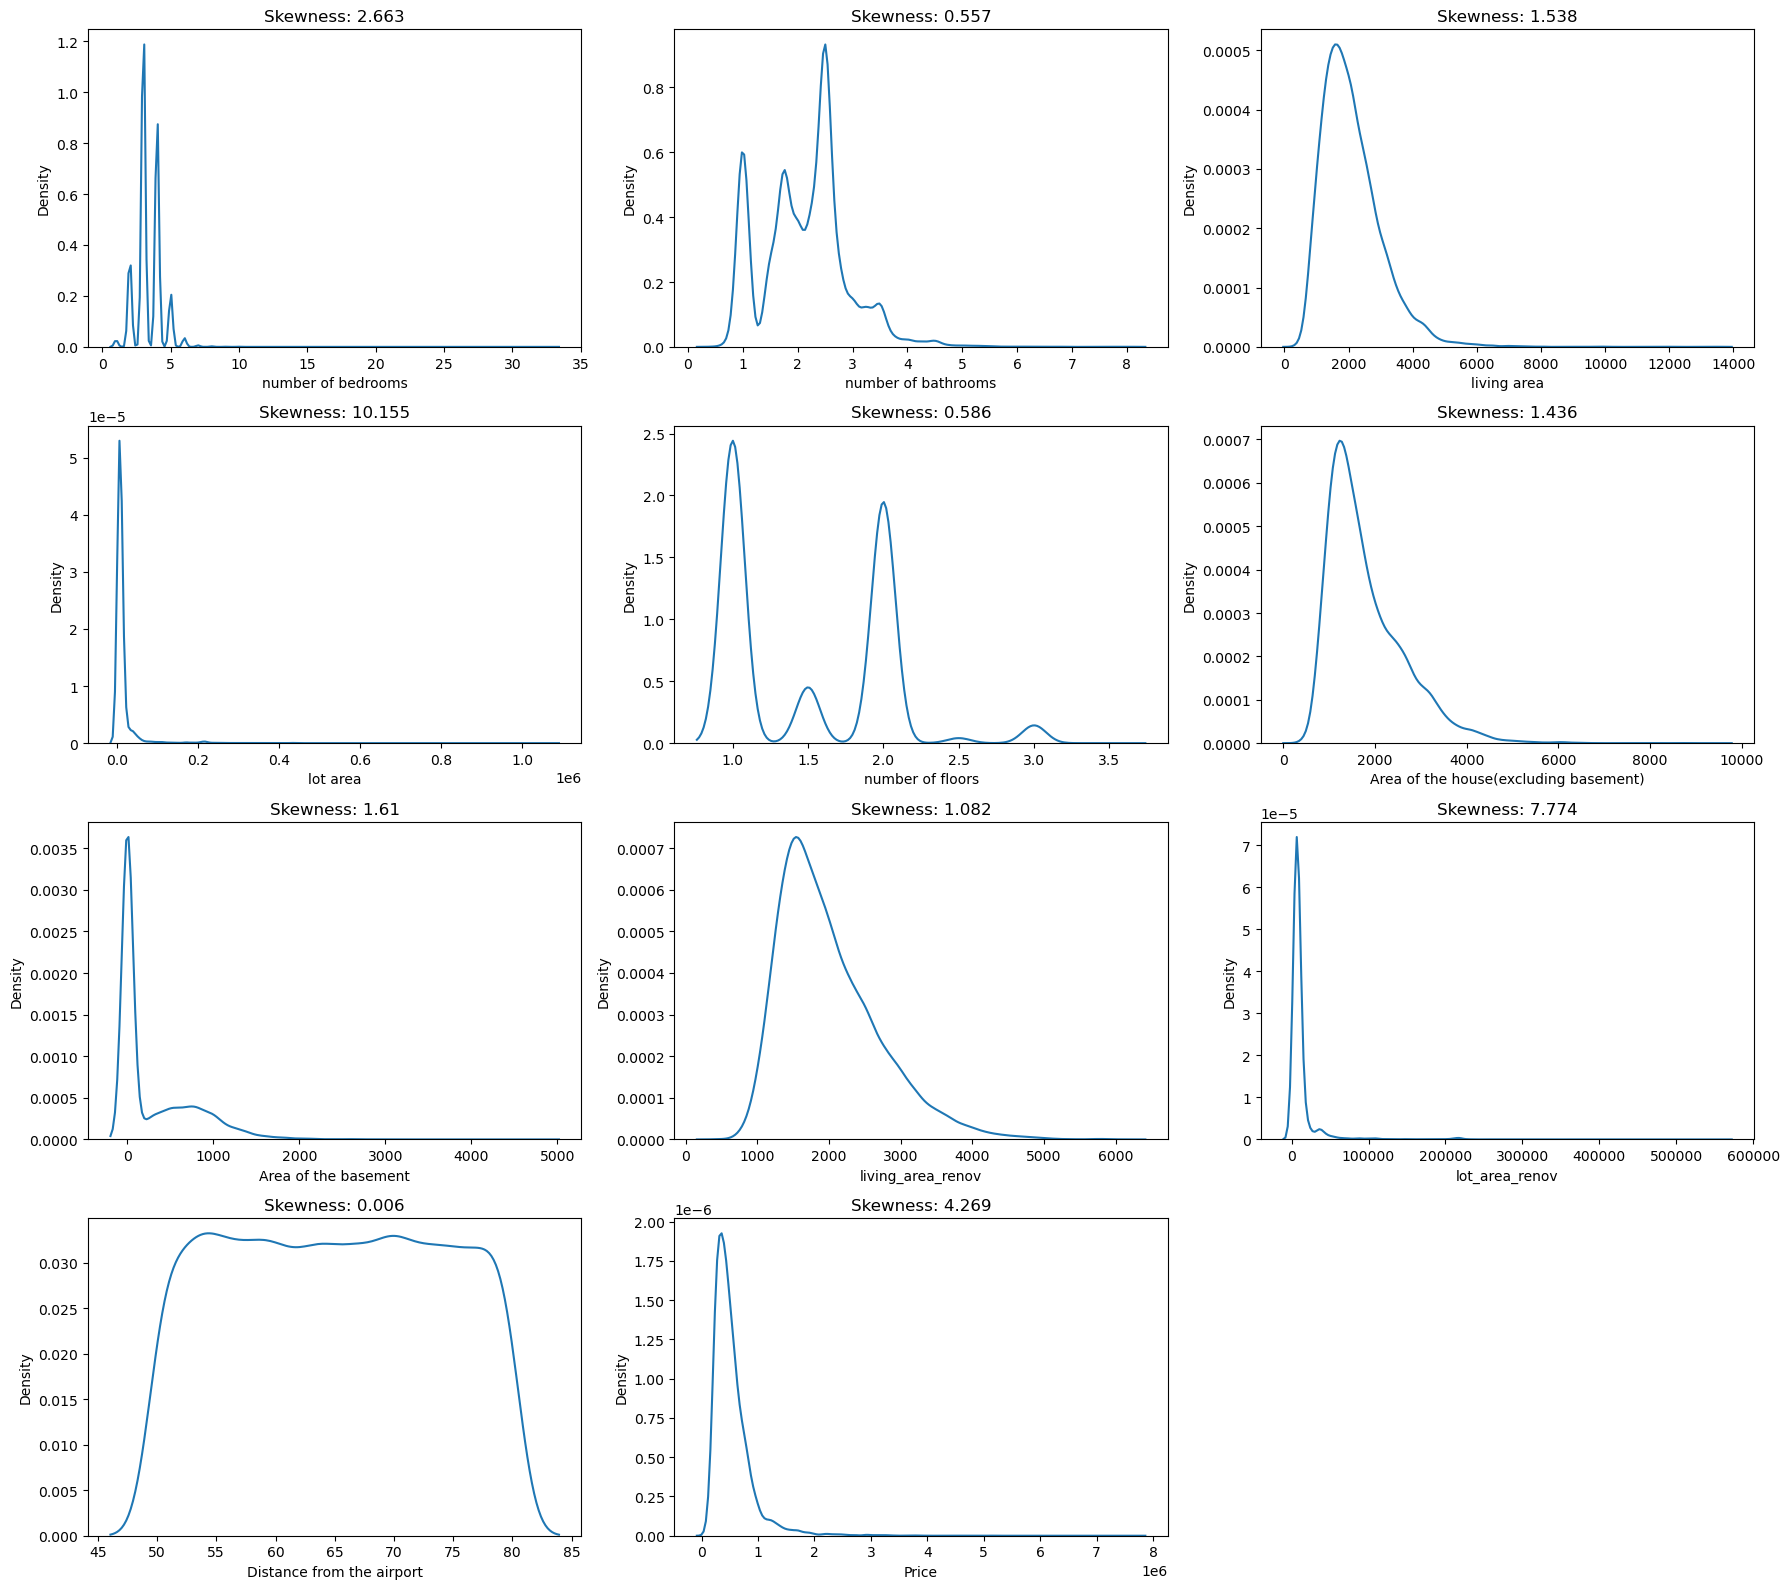

In [10]:
# Dist Plot
t = 1
plt.figure(figsize=(18,16))
for i in num_cols:
    plt.subplot(4,3,t)
    sns.distplot(data_2016[i],hist=False)
    plt.title(f"Skewness: {round(data_2016[i].skew(),3)}")
    t += 1
plt.tight_layout()
plt.show()

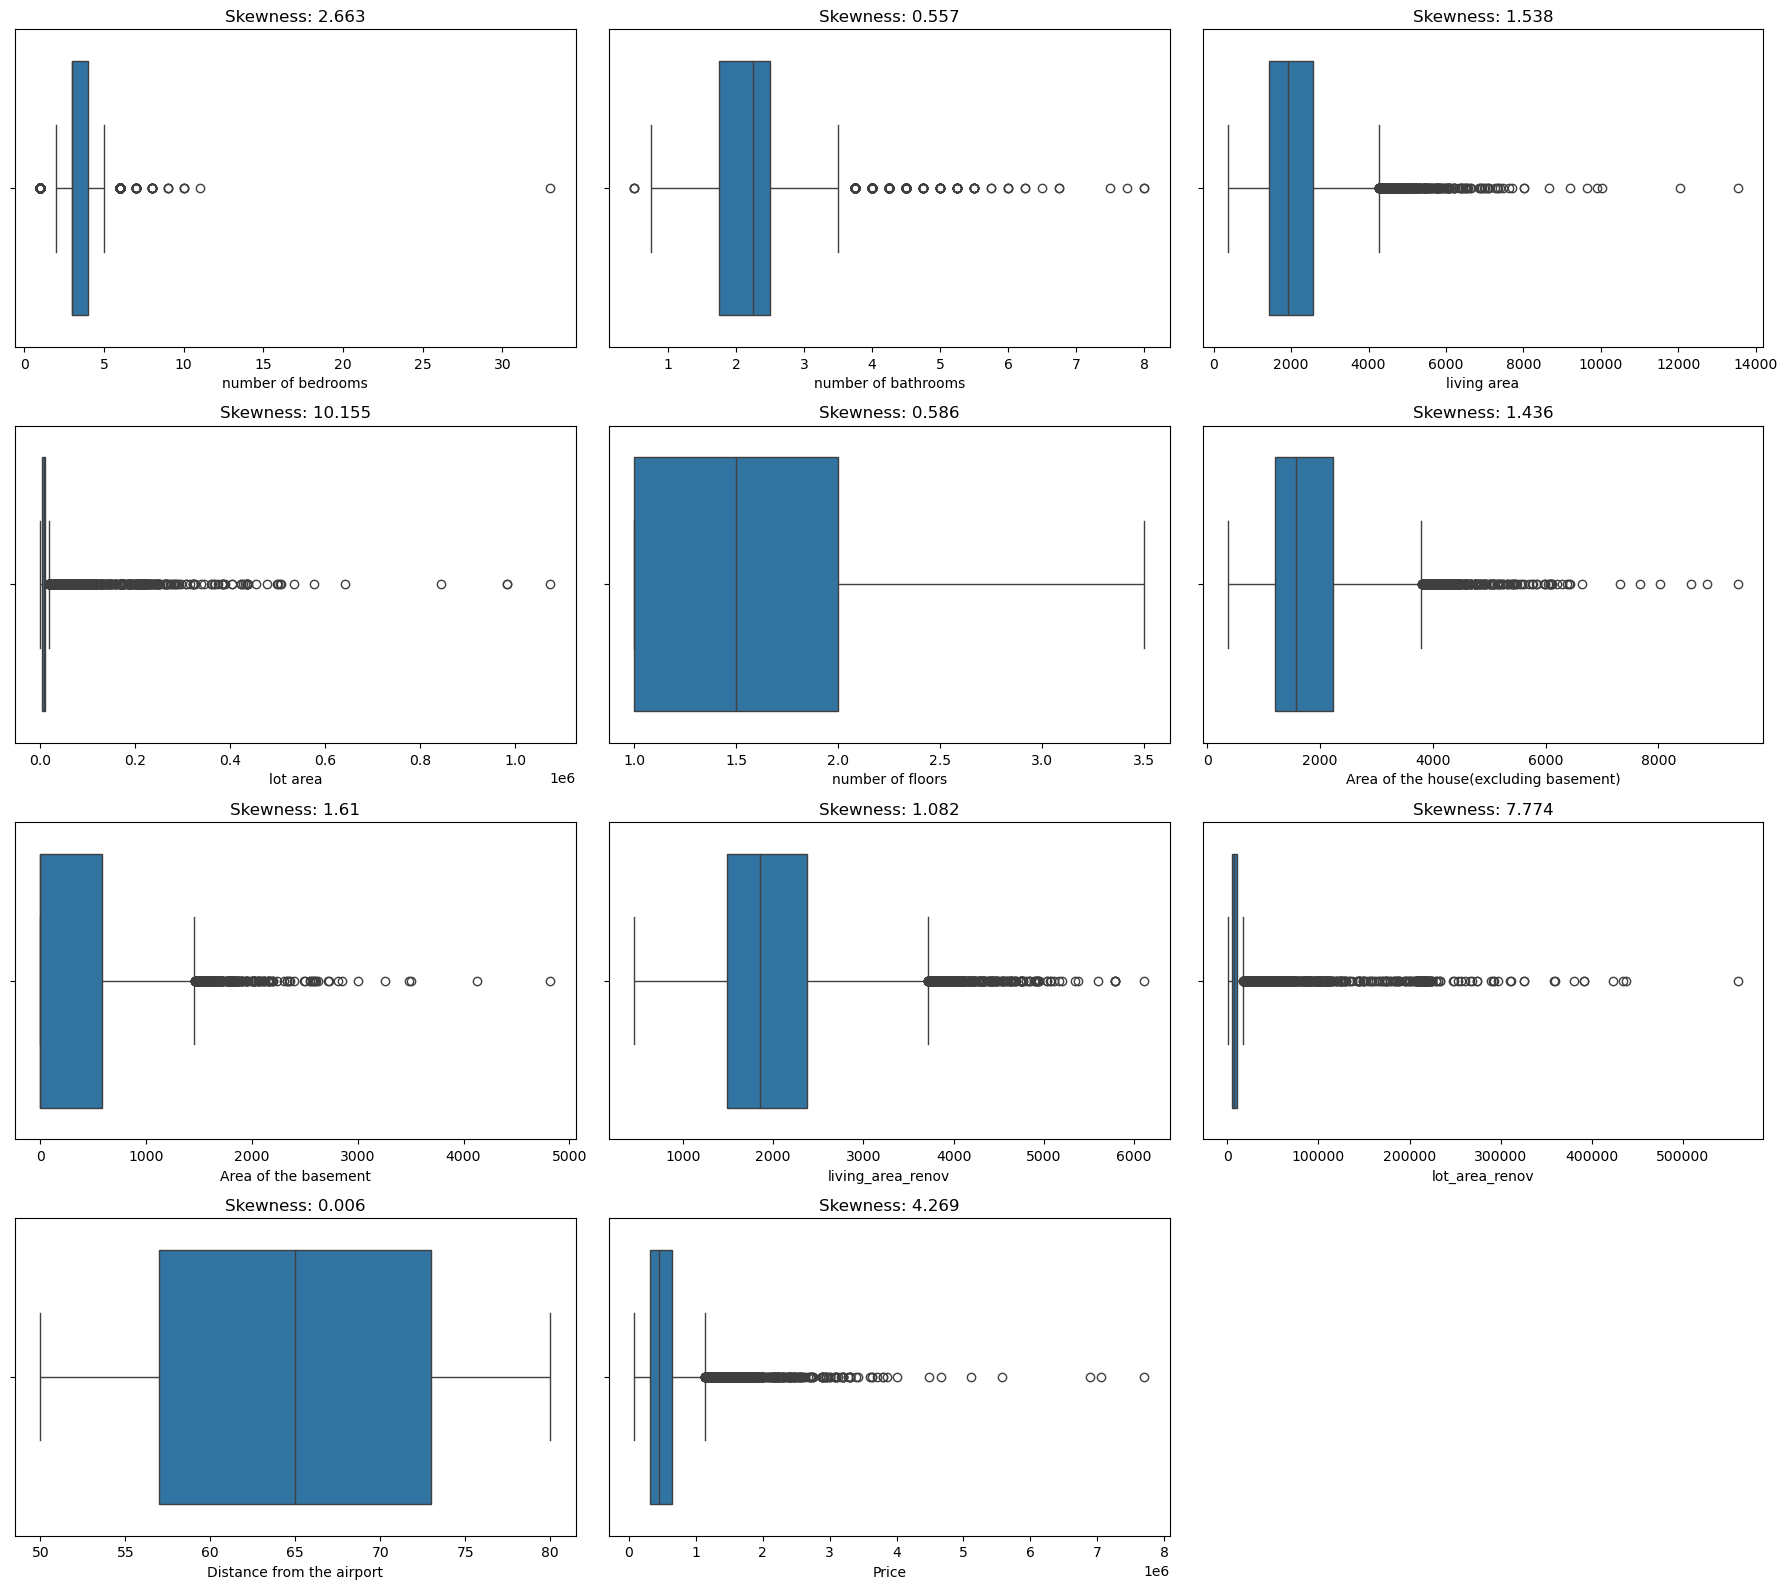

In [11]:
# Box Plot
t = 1
plt.figure(figsize=(18,16))
for i in num_cols:
    plt.subplot(4,3,t)
    sns.boxplot(data_2016[i],orient='h')
    plt.title(f"Skewness: {round(data_2016[i].skew(),3)}")
    t += 1
plt.tight_layout()
plt.show()

### ***`Categorical Columns`***

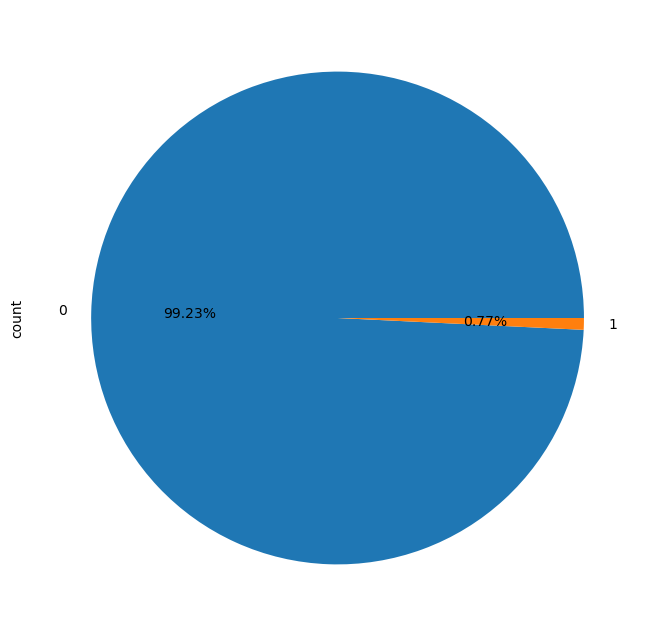

In [12]:
plt.figure(figsize=(12,8))
data_2016['waterfront present'].value_counts().plot(kind='pie',autopct='%.2f%%')
plt.show()

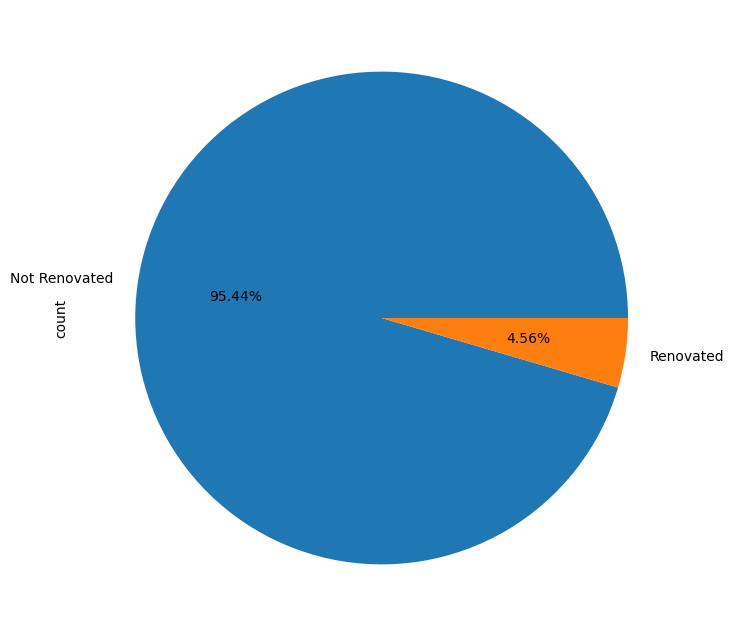

In [13]:
plt.figure(figsize=(12,8))
data_2016['Renovation'].value_counts().plot(kind='pie',autopct='%.2f%%')
plt.show()

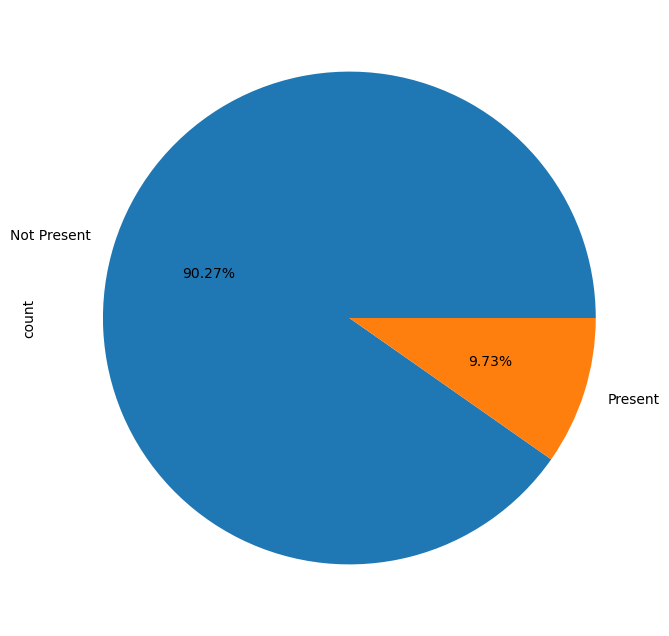

In [14]:
plt.figure(figsize=(12,8))
data_2016['View'].value_counts().plot(kind='pie',autopct='%.2f%%')
plt.show()

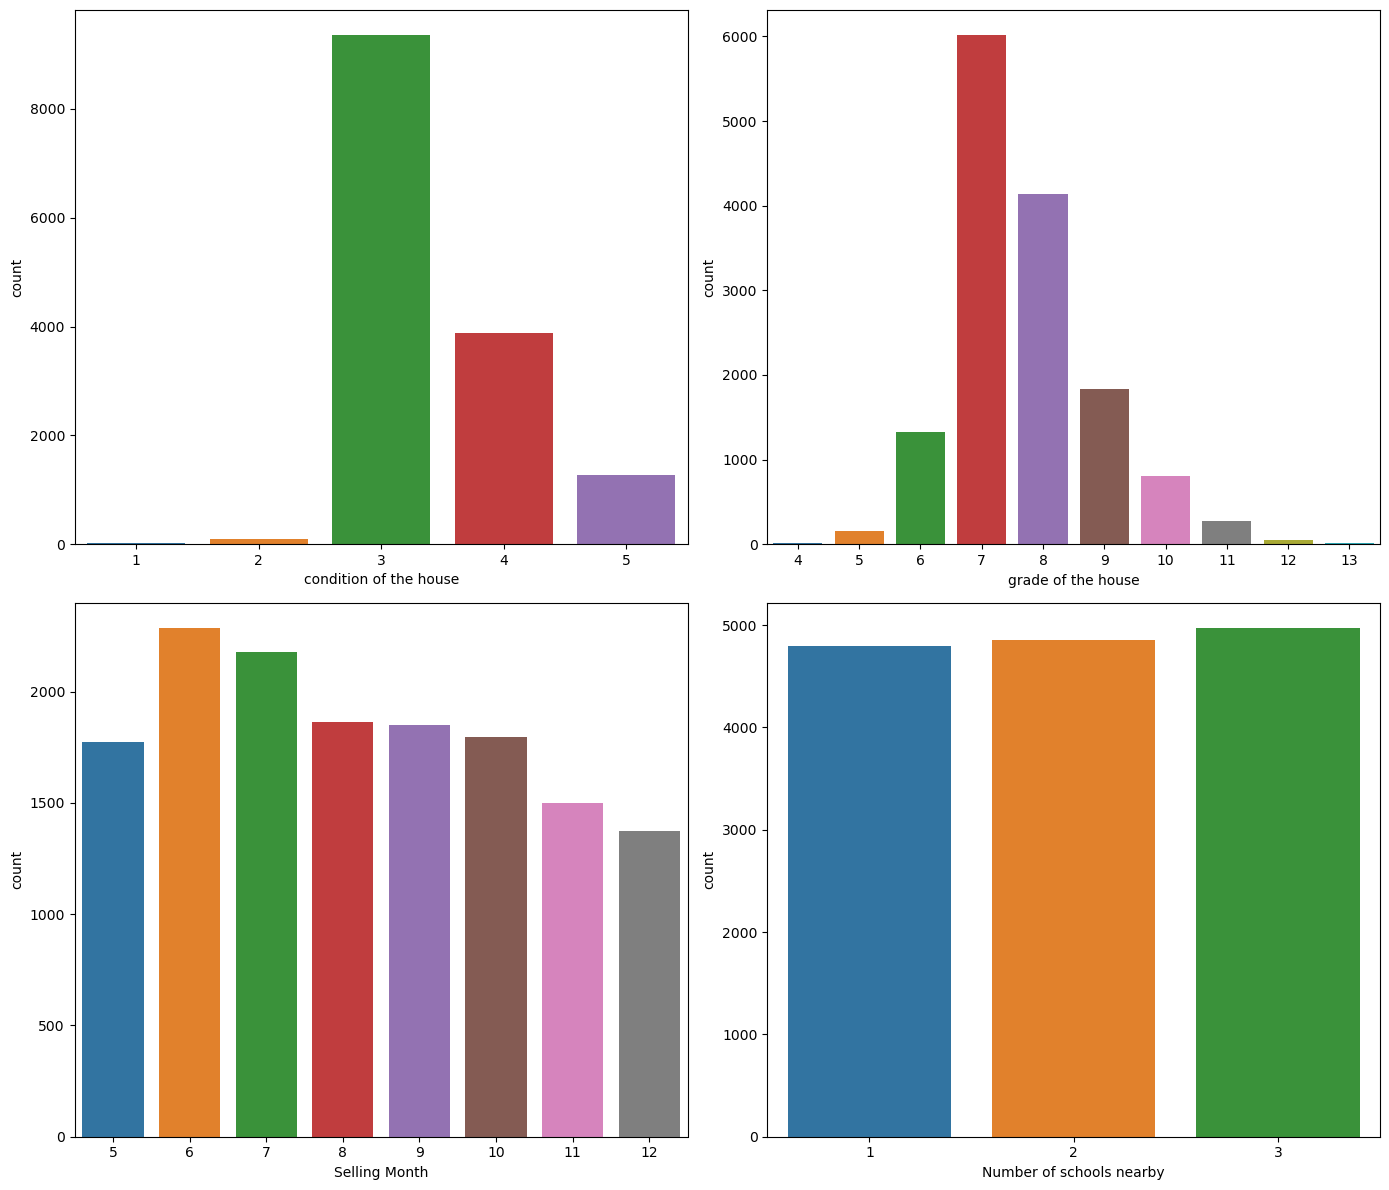

In [15]:
t = 1
plt.figure(figsize=(14,12))
for i in cat_cols:
    if i not in ['waterfront present','Built Year','Renovation','View']:
        plt.subplot(2,2,t)
        sns.countplot(data=data_2016,x=i,palette='tab10')
        t += 1
plt.tight_layout()
plt.show()

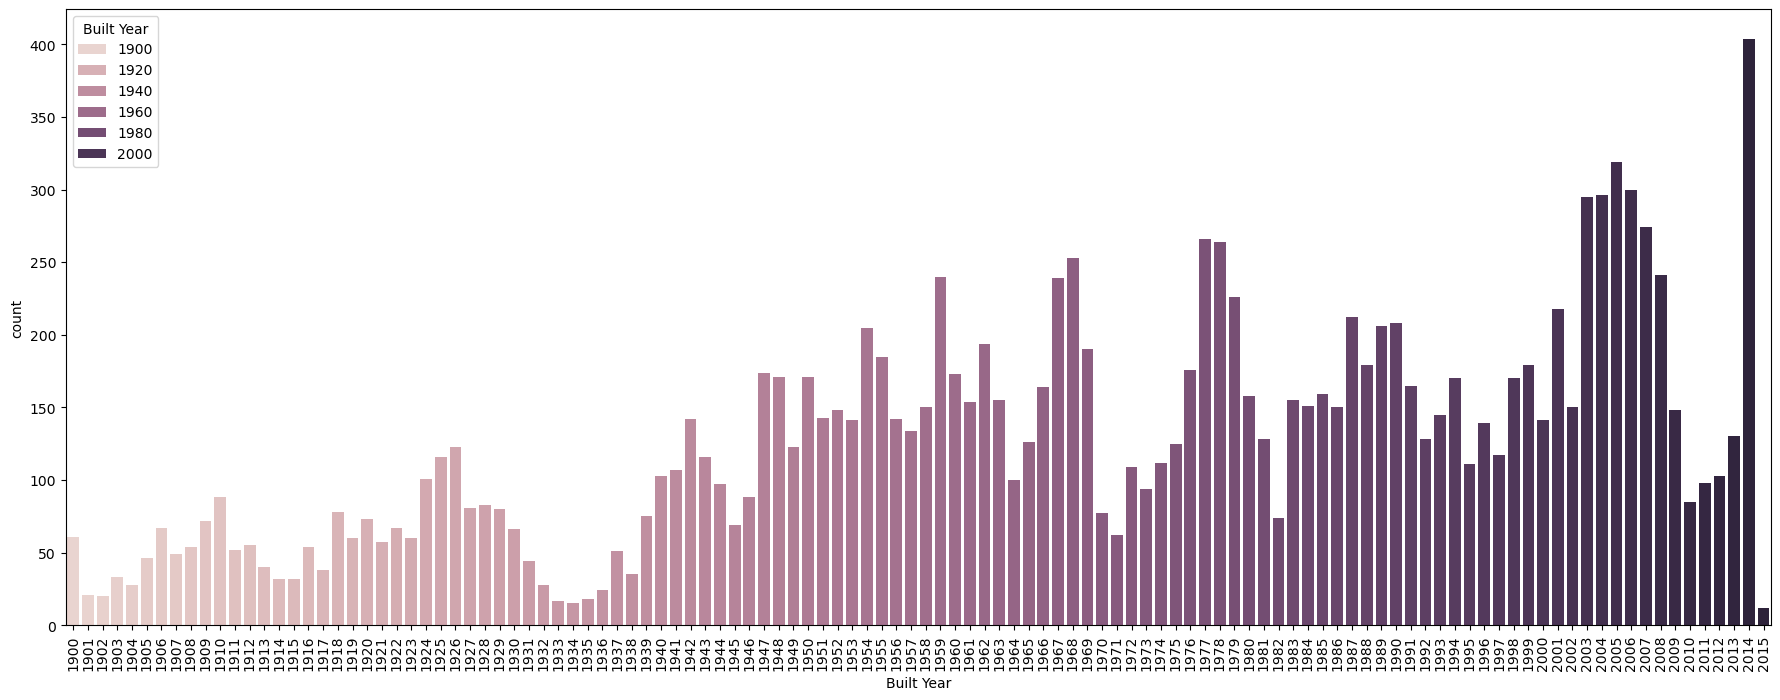

In [16]:
plt.figure(figsize=(22,8))
sns.countplot(data=data_2016,x='Built Year',hue='Built Year')
plt.xticks(rotation=90)
plt.show()

# ***`Bivariate Analysis`***

### ***`Numerical vs Numerical`***

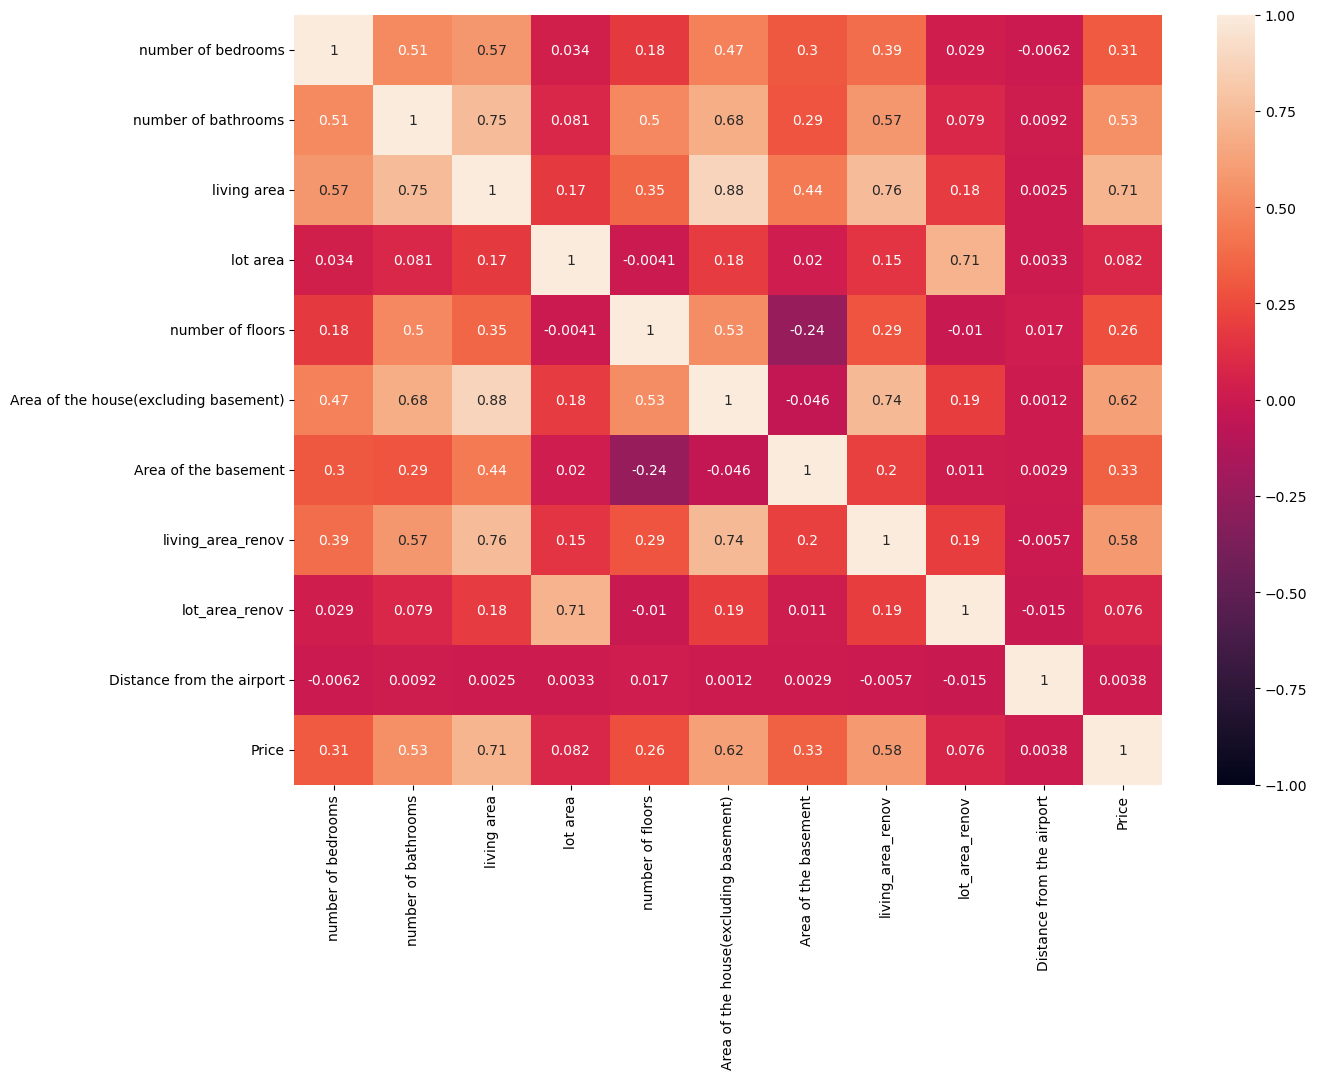

In [17]:
plt.figure(figsize=(14,10))
sns.heatmap(data_2016[num_cols].corr(),vmin=-1,vmax=1,annot=True)
plt.show()

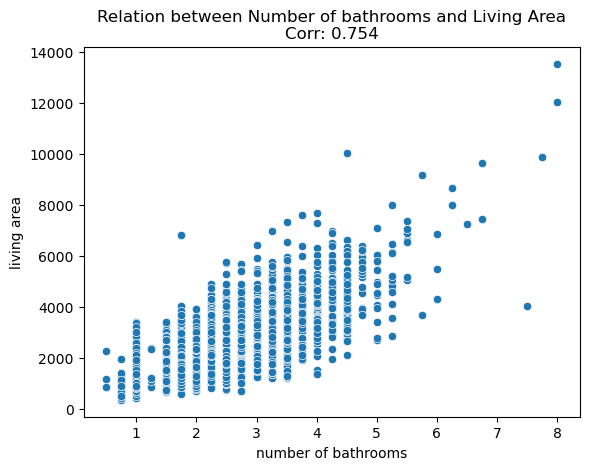

In [18]:
sns.scatterplot(data=data_2016,x='number of bathrooms',y='living area')
plt.title(f"Relation between Number of bathrooms and Living Area\nCorr: {round(data_2016['number of bathrooms'].corr(data_2016['living area']),3)}")
plt.show()

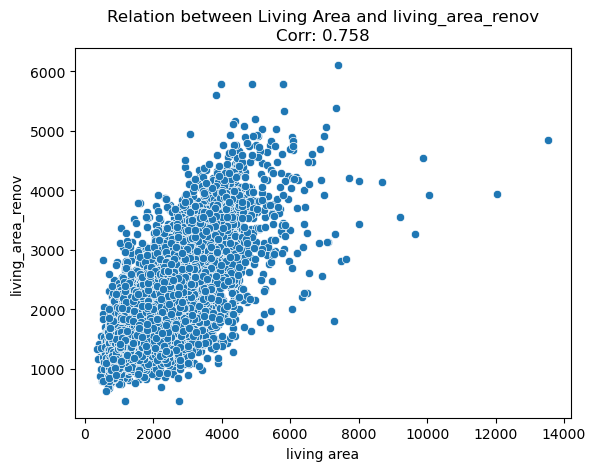

In [19]:
sns.scatterplot(data=data_2016,x='living area',y='living_area_renov')
plt.title(f"Relation between Living Area and living_area_renov\nCorr: {round(data_2016['living area'].corr(data_2016['living_area_renov']),3)}")
plt.show()

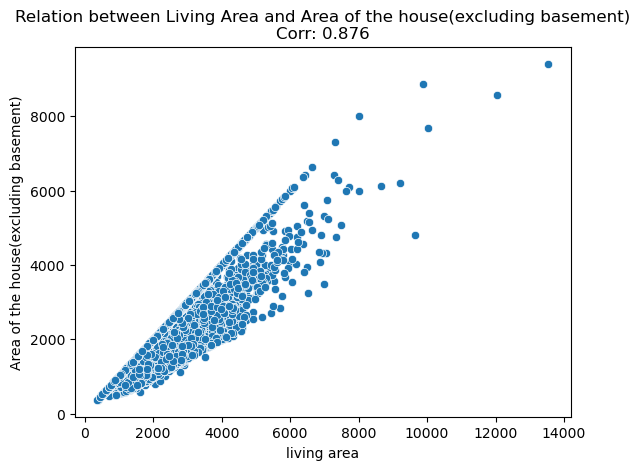

In [20]:
sns.scatterplot(data=data_2016,x='living area',y='Area of the house(excluding basement)')
plt.title(f"Relation between Living Area and Area of the house(excluding basement)\nCorr: {round(data_2016['living area'].corr(data_2016['Area of the house(excluding basement)']),3)}")
plt.show()

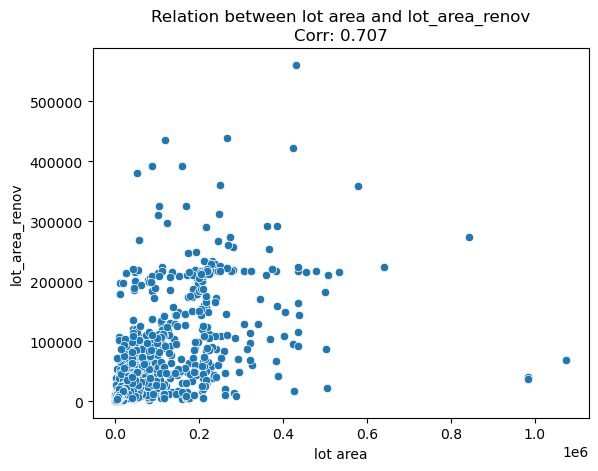

In [21]:
sns.scatterplot(data=data_2016,x='lot area',y='lot_area_renov')
plt.title(f"Relation between lot area and lot_area_renov\nCorr: {round(data_2016['lot area'].corr(data_2016['lot_area_renov']),3)}")
plt.show()

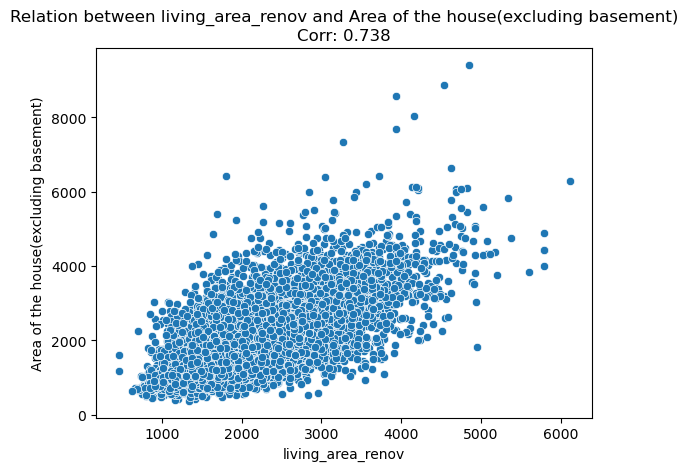

In [22]:
sns.scatterplot(data=data_2016,x='living_area_renov',y='Area of the house(excluding basement)')
plt.title(f"Relation between living_area_renov and Area of the house(excluding basement)\nCorr: {round(data_2016['living_area_renov'].corr(data_2016['Area of the house(excluding basement)']),3)}")
plt.show()

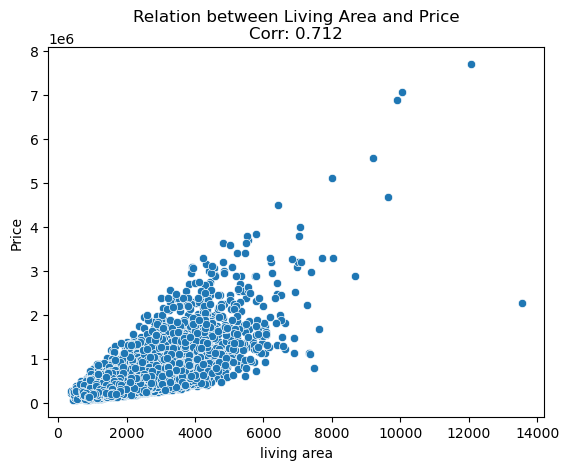

In [23]:
sns.scatterplot(data=data_2016,x='living area',y='Price')
plt.title(f"Relation between Living Area and Price\nCorr: {round(data_2016['living area'].corr(data_2016['Price']),3)}")
plt.show()

### ***`Categorical vs Numerical`***

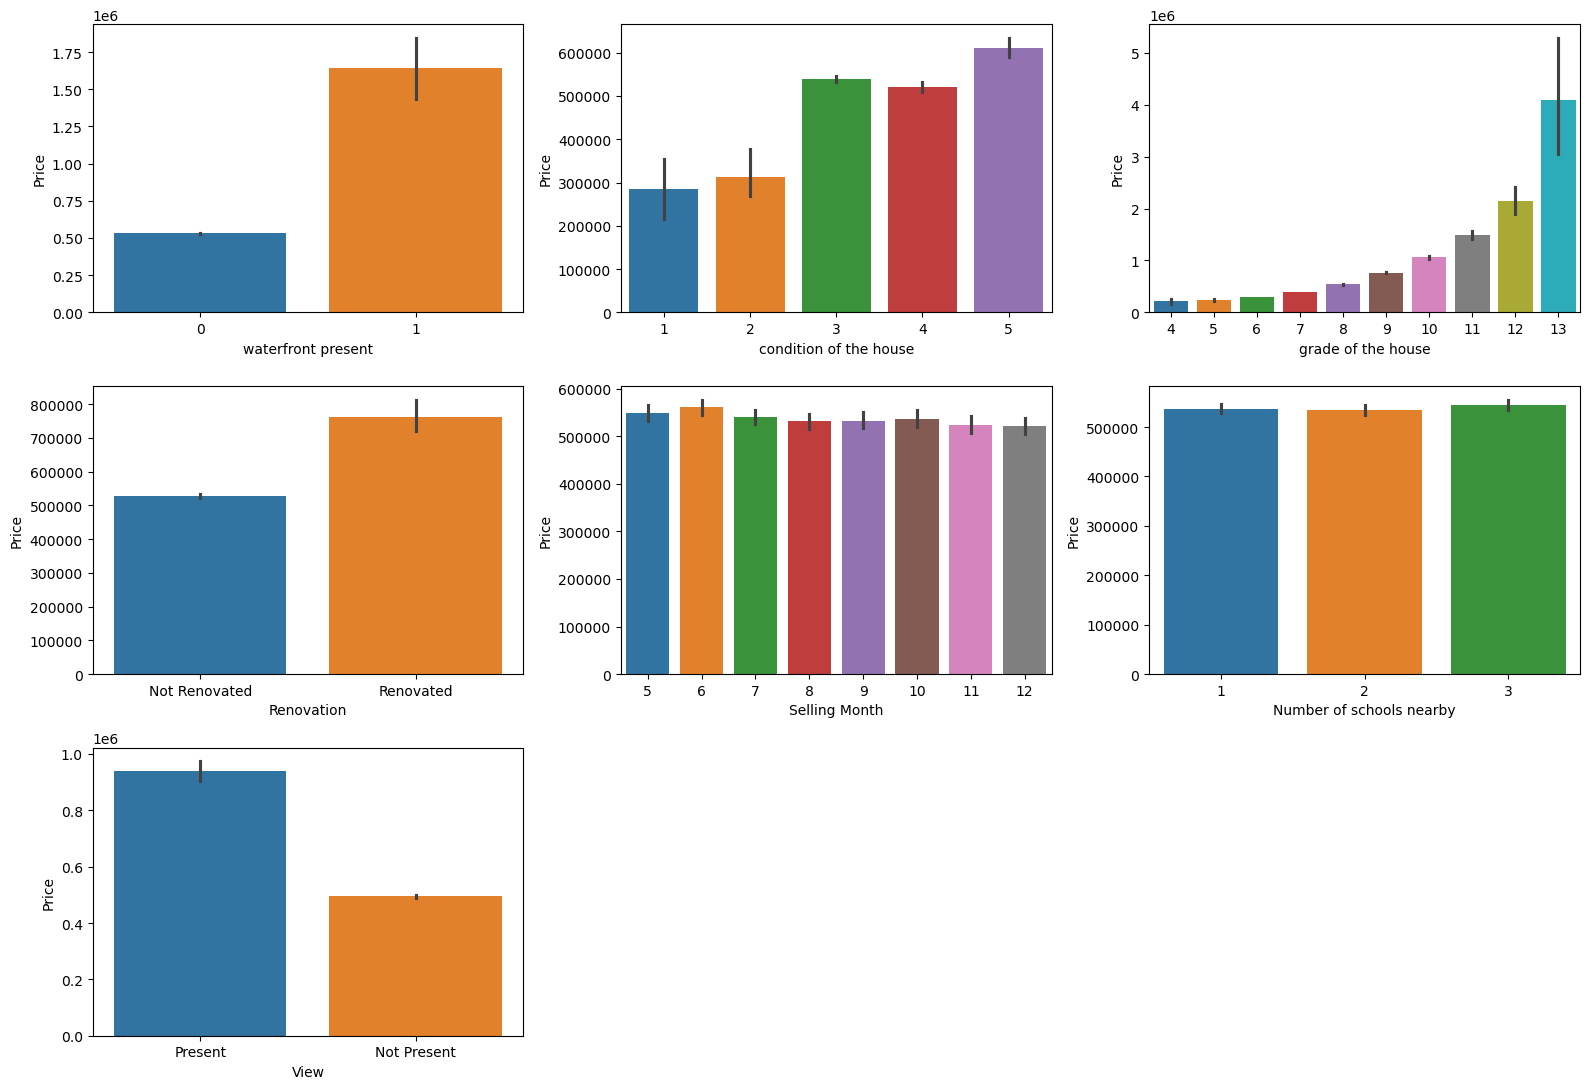

In [24]:
t = 1
plt.figure(figsize=(16,11))
for i in cat_cols:
    if i != 'Built Year':
        plt.subplot(3,3,t)
        sns.barplot(data=data_2016,x=i,y='Price',palette='tab10')
        t += 1
plt.tight_layout()
plt.show()

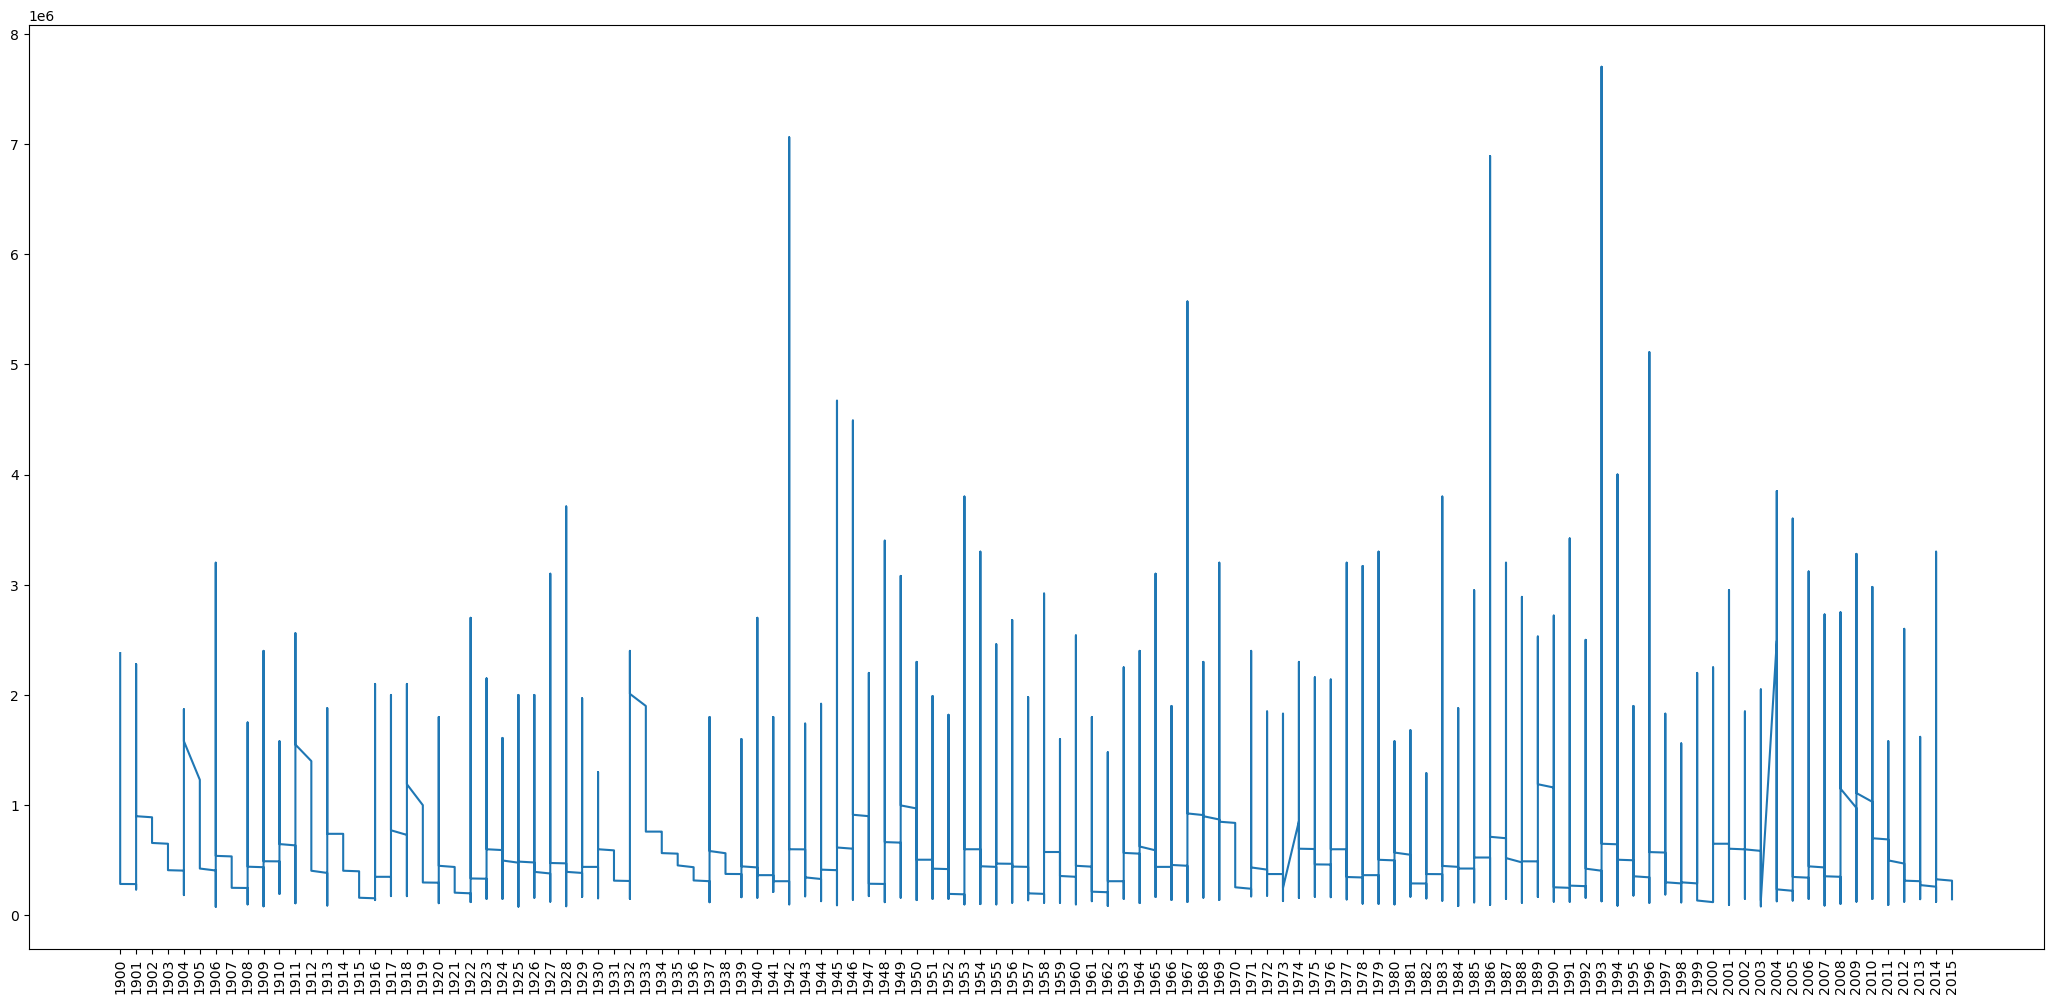

In [25]:
plt.figure(figsize=(26,12))
plt.plot(data_2016['Built Year'].sort_values().astype(str),data_2016['Price'])
plt.xticks(rotation=90)
plt.show()

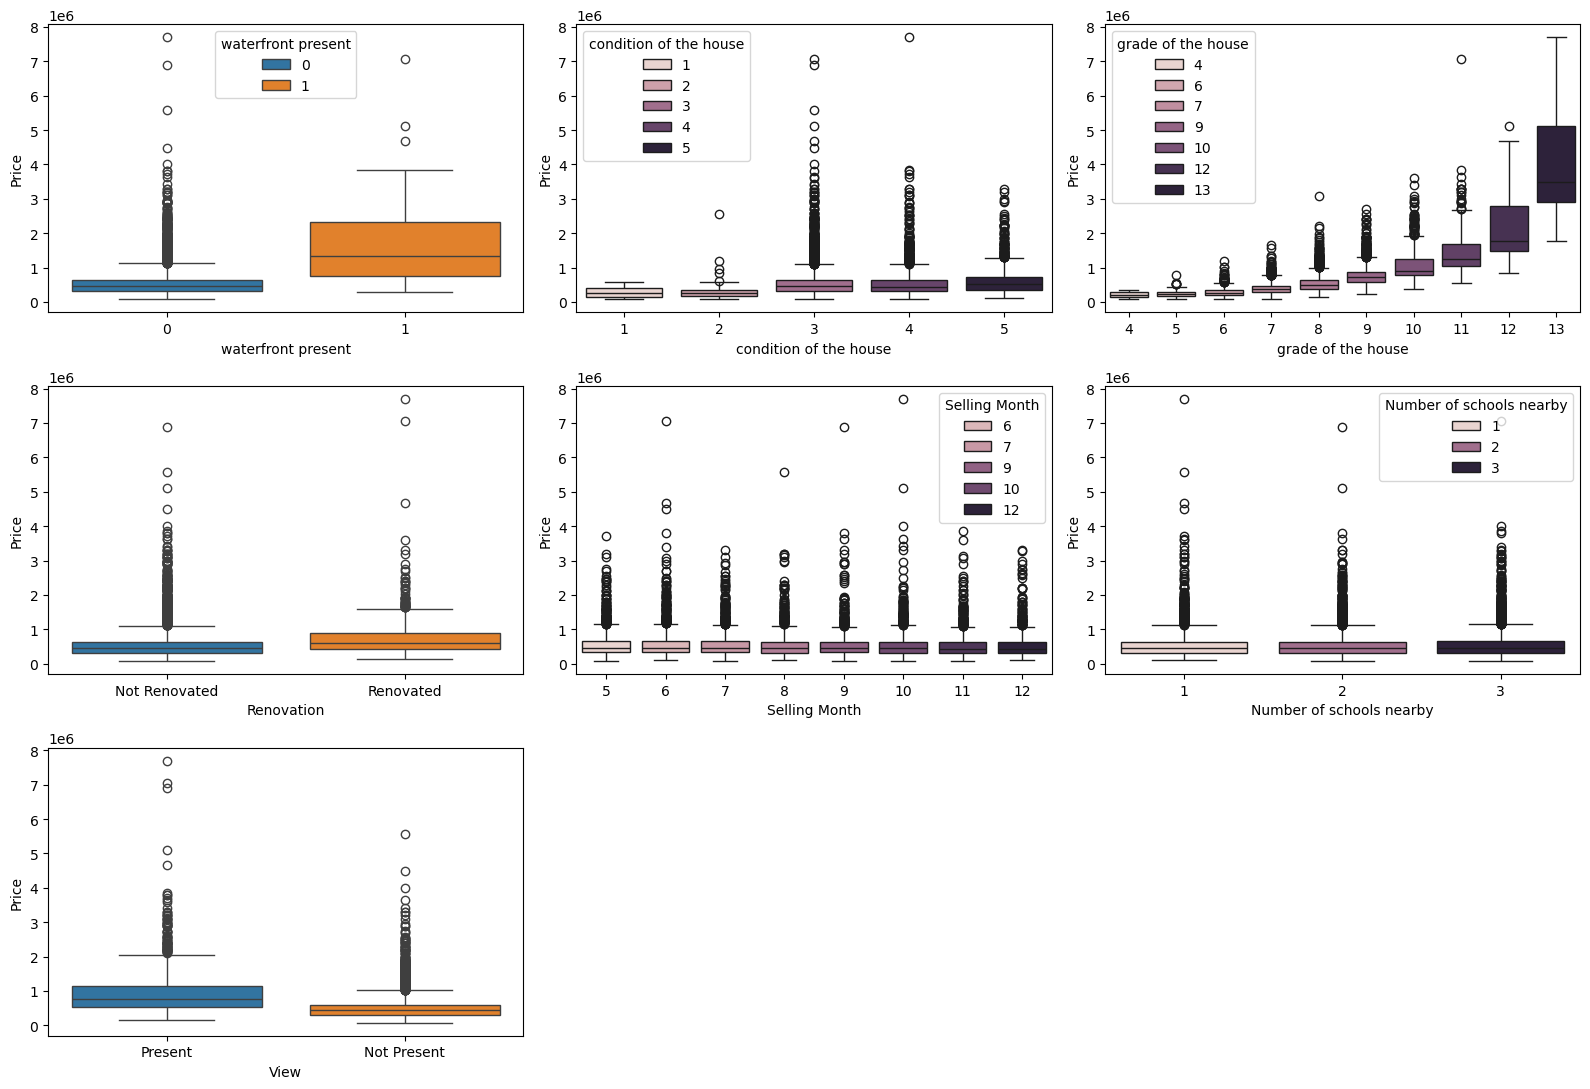

In [26]:
t = 1
plt.figure(figsize=(16,11))
for i in cat_cols:
    if i != 'Built Year':
        plt.subplot(3,3,t)
        sns.boxplot(data=data_2016,x=i,y='Price',hue=i)
        t += 1
plt.tight_layout()
plt.show()

# ***`Data Preprocessing`***

### ***`Outliers`***

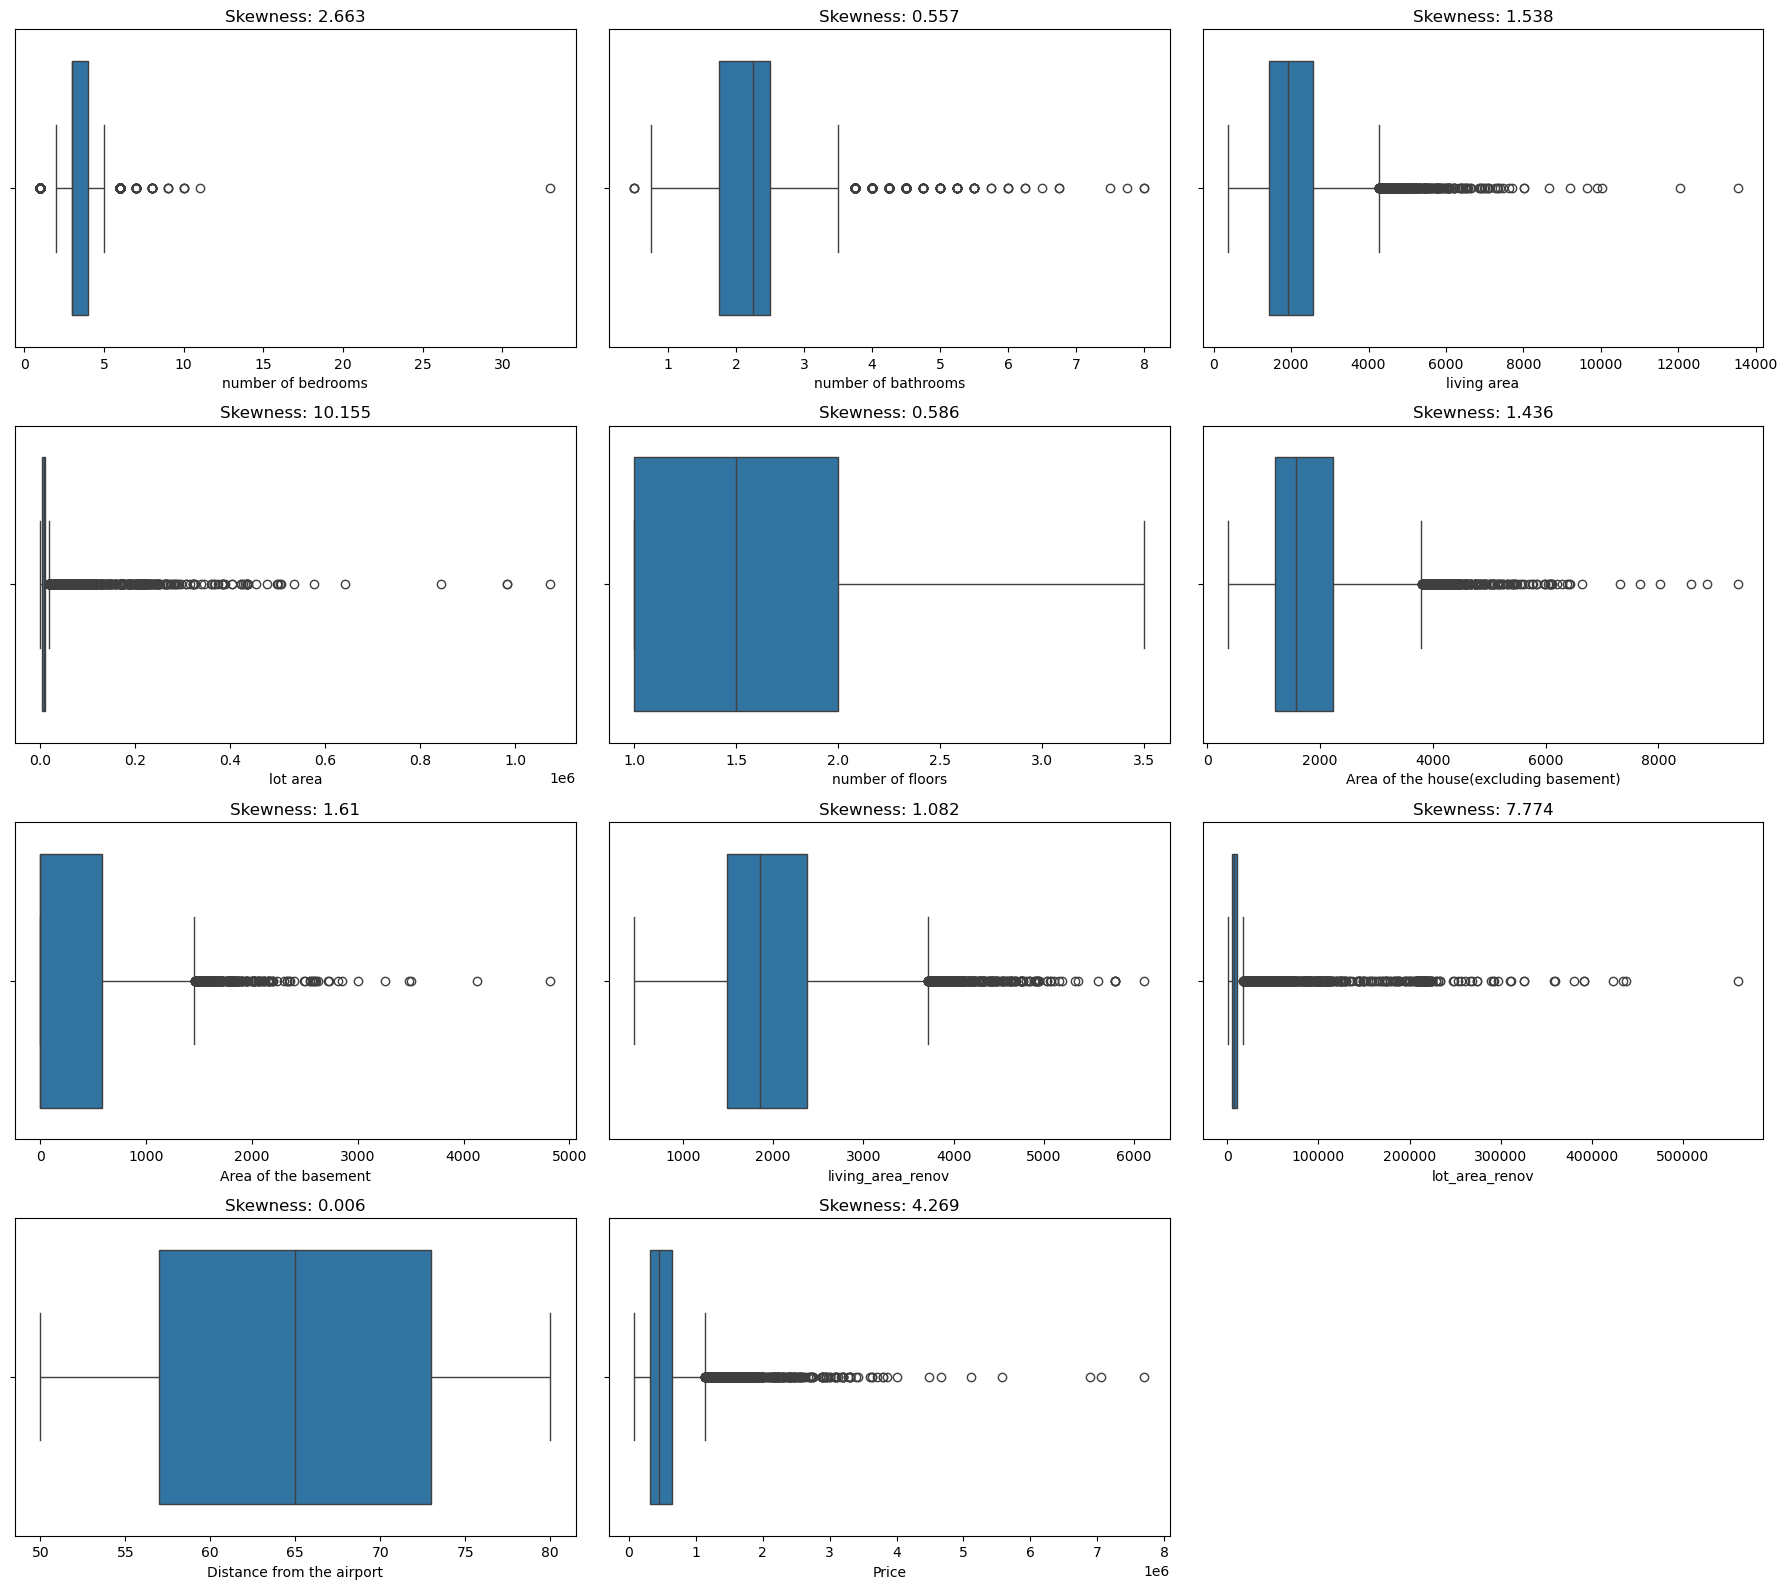

In [27]:
t = 1
plt.figure(figsize=(18,16))
for i in num_cols:
    plt.subplot(4,3,t)
    sns.boxplot(data_2016[i],orient='h')
    plt.title(f"Skewness: {round(data_2016[i].skew(),3)}")
    t += 1
plt.tight_layout()
plt.show()

In [28]:
# 2016 
# Capping
for i in num_cols:
    q1 = np.percentile(data_2016[i],25)
    q3 = np.percentile(data_2016[i],75)
    iqr = q3 - q1
    ll = q1 - 1.5*iqr
    ul = q3 + 1.5*iqr
    data_2016[i] = data_2016[i].apply(lambda x: ll if x < ll else ul if x > ul else x)

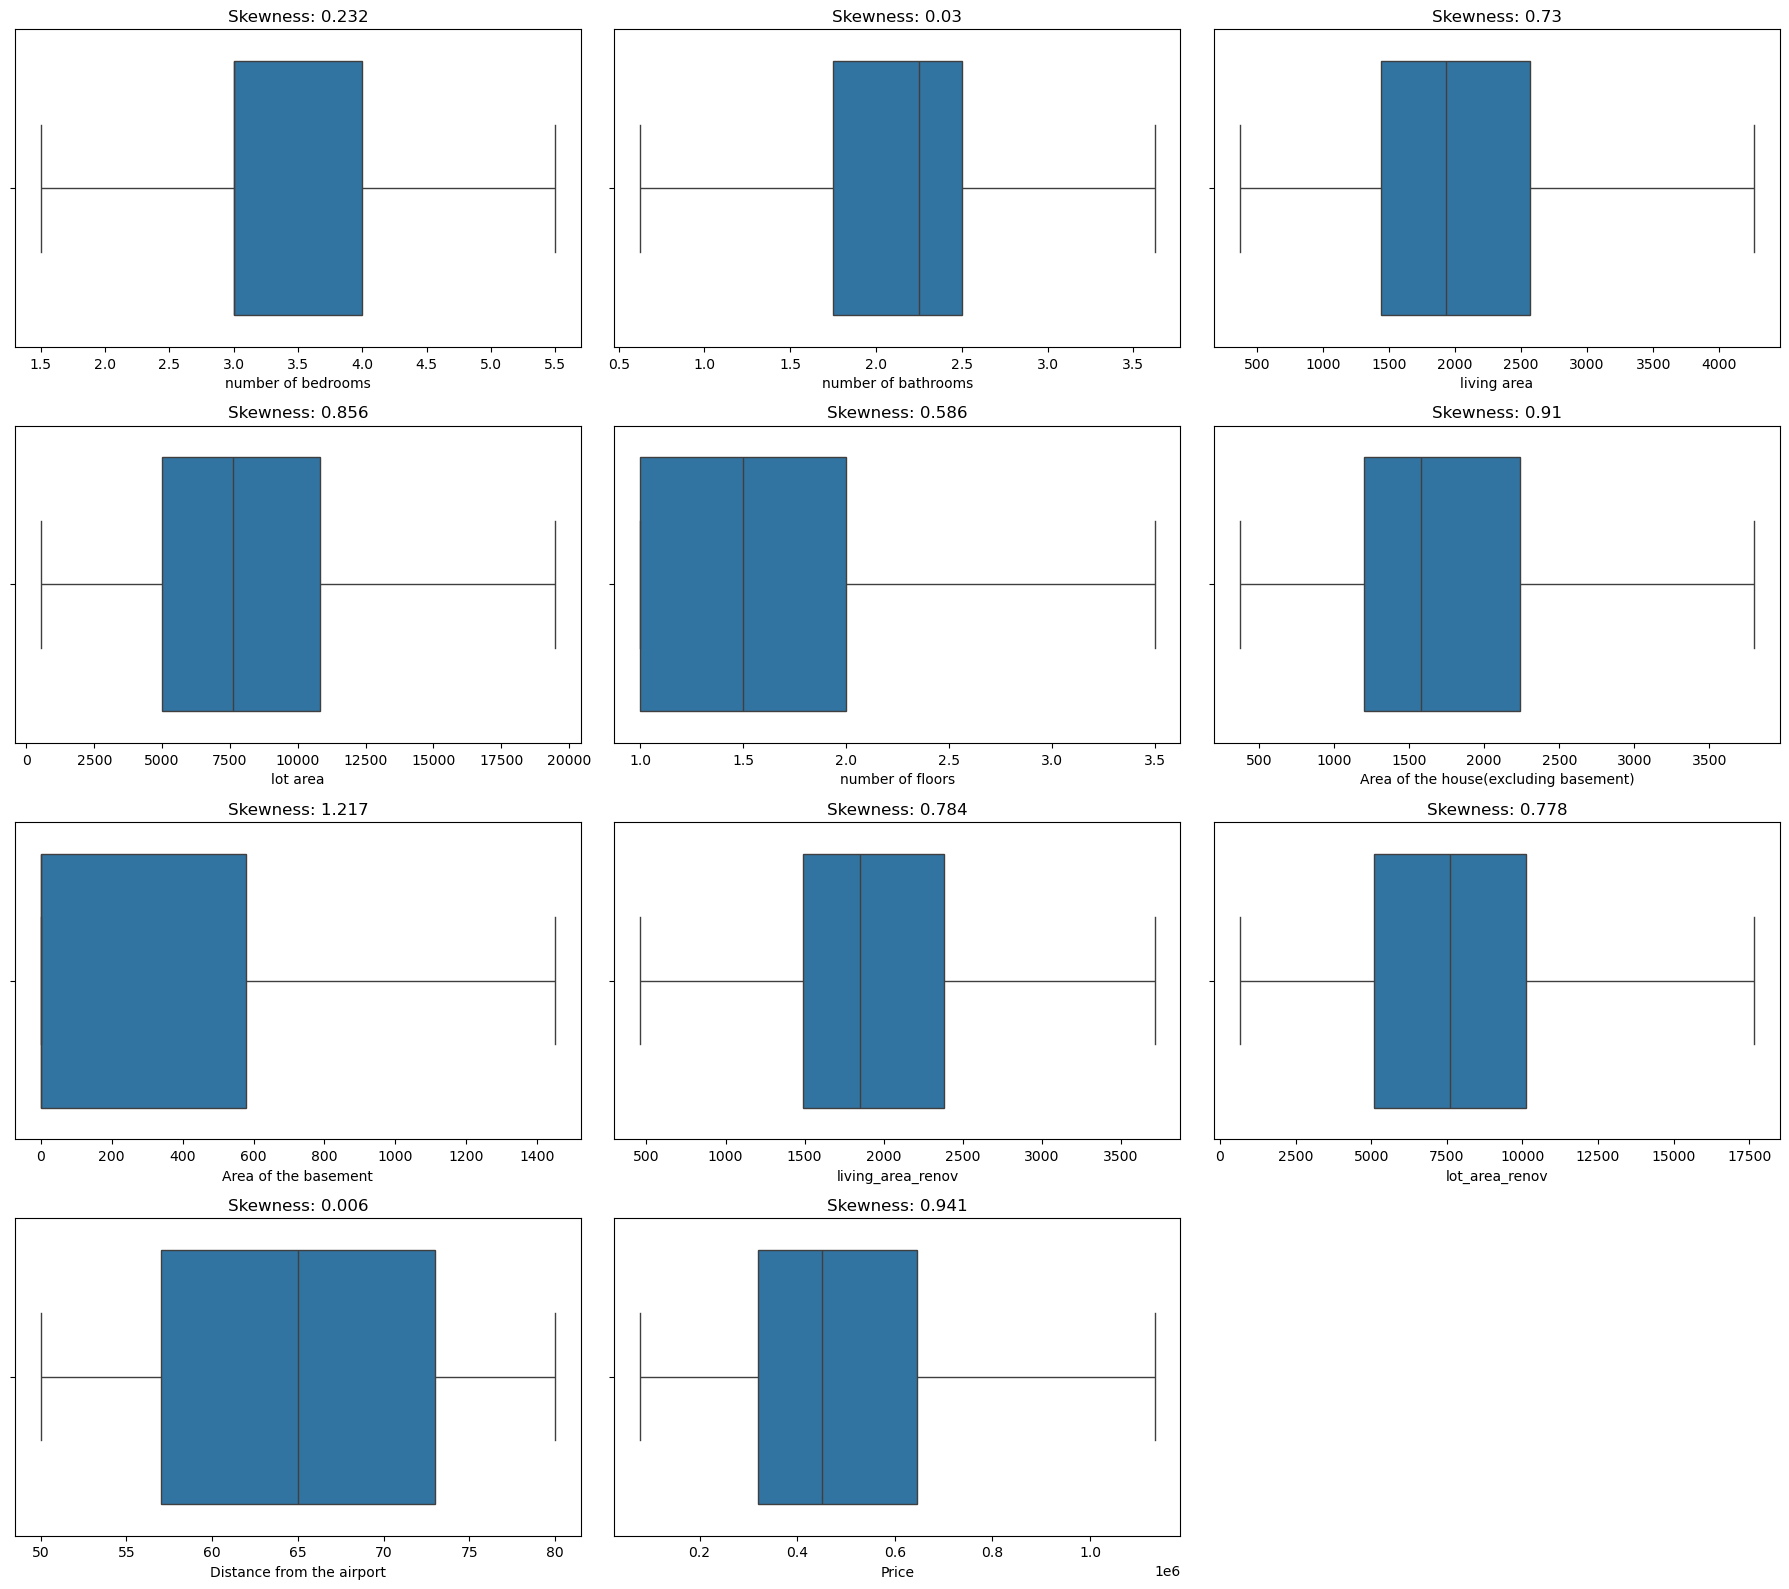

In [29]:
t = 1
plt.figure(figsize=(18,16))
for i in num_cols:
    plt.subplot(4,3,t)
    sns.boxplot(data_2016[i],orient='h')
    plt.title(f"Skewness: {round(data_2016[i].skew(),3)}")
    t += 1
plt.tight_layout()
plt.show()

### ***`Encoding`***

In [30]:
# Renovation
data_2016['Renovation'] = data_2016['Renovation'].map({'Not Renovated':0,'Renovated':1})

# View
data_2016['View'] = data_2016['View'].map({'Not Present':0,'Present':1})

### ***`Feature Engineering`***

In [31]:
# number of bathrooms
data_2016['number of bathrooms'] = data_2016['number of bathrooms'].astype(int)

# number of floors
data_2016['number of floors'] = data_2016['number of floors'].astype(int)

# number of bedrooms
data_2016['number of bedrooms'] = data_2016['number of bedrooms'].astype(int)

## ***`Train Test Split`***

In [32]:
x = data_2016.drop(columns='Price')
y = data_2016['Price']

# Train Test Split
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=0.80,random_state=43)

In [33]:
# Dimensions of Training and Testing Data
print(f"Dimensions of Training Data: {x_train.shape,y_train.shape}\nDimensions of Testing Data: {x_test.shape,y_test.shape}")

Dimensions of Training Data: ((11696, 18), (11696,))
Dimensions of Testing Data: ((2924, 18), (2924,))


# ***`Regression Analysis`***

In [34]:
model = sma.OLS(y,sma.add_constant(x)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     1835.
Date:                Thu, 23 Jan 2025   Prob (F-statistic):               0.00
Time:                        16:53:42   Log-Likelihood:            -1.9383e+05
No. Observations:               14620   AIC:                         3.877e+05
Df Residuals:                   14601   BIC:                         3.878e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

### ***`Assumptions`***

In [35]:
#1 The Target Variable must be Numeric.
data_2016['Price'].dtype

dtype('float64')

In [36]:
#2 There must be no Multicollinearity
vif = []

for i in range(x.shape[1]):
    vif.append(variance_inflation_factor(x.values,i))

pd.DataFrame({'VIF':vif},index=x.columns)

,VIF
number of bedrooms,28.922577
number of bathrooms,17.277481
living area,565.292753
lot area,19.859970
number of floors,17.488335
waterfront present,1.104606
condition of the house,30.076185
grade of the house,137.930651
Area of the house(excluding basement),432.516360
Area of the basement,28.705781


In [37]:
#3 Linear Relation between the predictor and the target variable
resid_data = x.copy()
resid_data['Residuals'] = model.resid

In [38]:
# Rainbow Test
# Ho: Variables are Linear
# Ha: Variables are not Linear

test_stat, p_value = linear_rainbow(model)
print(f"Test_Statistic: {test_stat}\tp_value: {p_value}")

if p_value < 0.05:
    print("Reject Ho")
else:
    print("Failed to Reject Ho")

Test_Statistic: 1.0914010928729525	p_value: 9.359285125223101e-05
Reject Ho


In [39]:
#4 There must be No Auto-Correlation
d = 1.355

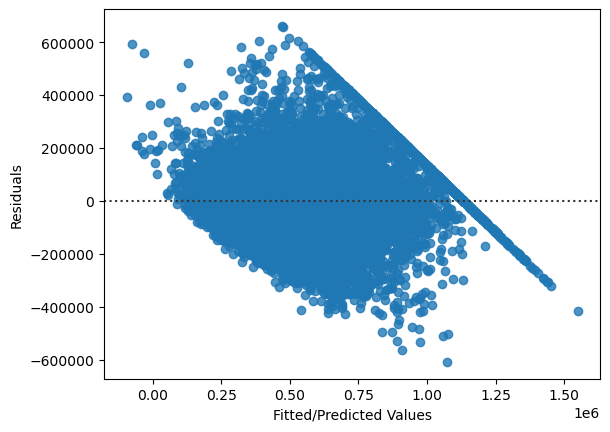

In [40]:
#5 Residuals must be Homoscedastic
# Resid Plot
sns.residplot(x=model.fittedvalues,y=model.resid)
plt.xlabel('Fitted/Predicted Values')
plt.ylabel('Residuals')
plt.show()

In [41]:
# Breucsch-Pagen Test
# Ho: The Variance is Same(Homoscedastic)
# Ha: The Variance is not same(Heteroscedastic)

p_value = sma.stats.diagnostic.het_breuschpagan(resid=model.resid,exog_het=sma.add_constant(x).values)[1]
print(f"tp_value: {p_value}")

if p_value < 0.05:
    print("Reject Ho")
else:
    print("Failed to Reject Ho")

tp_value: 7.005388676284438e-132
Reject Ho


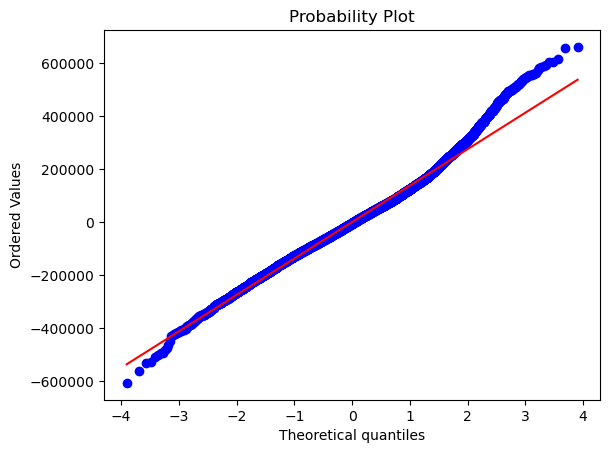

In [42]:
#6 Residuals must be Normally Distributed
# QQ Plot
stats.probplot(model.resid,plot=plt)
plt.show()

In [43]:
# Shapiro Test
# Ho: Data is normal
# Ha: Data is not normal
test_stat, p_value = stats.shapiro(model.resid)
print(f"Test_Statistic: {test_stat}\tp_value: {p_value}")

if p_value < 0.05:
    print("Reject Ho")
else:
    print("Failed to Reject Ho")

Test_Statistic: 0.9875958561897278	p_value: 1.344966106064306e-33
Reject Ho


# ***`Predictive Modelling`***

## ***`Linear Regression`***

In [44]:
model_lr = LinearRegression()
model_lr.fit(x_train,y_train)
y_lr_train = model_lr.predict(x_train)
y_lr_test = model_lr.predict(x_test)

In [45]:
# Train Metrics
print('R2: ',r2_score(y_train,y_lr_train))
print('MSE: ',mean_squared_error(y_train,y_lr_train))
print('RMSE: ',mean_squared_error(y_train,y_lr_train)**0.5)
print('MAE: ',mean_absolute_error(y_train,y_lr_train))
print('MAPE: ',mean_absolute_percentage_error(y_train,y_lr_train))

R2:  0.6937650178540036
MSE:  19238462148.36644
RMSE:  138702.78349177583
MAE:  106323.50419516841
MAPE:  0.24752406295608287


In [46]:
# Test Metrics
print('R2: ',r2_score(y_test,y_lr_test))
print('MSE: ',mean_squared_error(y_test,y_lr_test))
print('RMSE: ',mean_squared_error(y_test,y_lr_test)**0.5)
print('MAE: ',mean_absolute_error(y_test,y_lr_test))
print('MAPE: ',mean_absolute_percentage_error(y_test,y_lr_test))

R2:  0.6913102067203072
MSE:  19004230482.186977
RMSE:  137855.83223856354
MAE:  106259.95349862557
MAPE:  0.2534064672527506


## ***`DecisionTreeRegressor`***

In [47]:
model_dt = DecisionTreeRegressor(max_depth=4)
model_dt.fit(x_train,y_train)
y_dt_train = model_dt.predict(x_train)
y_dt_test = model_dt.predict(x_test)

In [48]:
# Train Metrics
print('R2: ',r2_score(y_train,y_dt_train))
print('MSE: ',mean_squared_error(y_train,y_dt_train))
print('RMSE: ',mean_squared_error(y_train,y_dt_train)**0.5)
print('MAE: ',mean_absolute_error(y_train,y_dt_train))
print('MAPE: ',mean_absolute_percentage_error(y_train,y_dt_train))

R2:  0.6294449214945748
MSE:  23279214548.75752
RMSE:  152575.27502435484
MAE:  117665.12911889023
MAPE:  0.28434365318016874


In [49]:
# Test Metrics
print('R2: ',r2_score(y_test,y_dt_test))
print('MSE: ',mean_squared_error(y_test,y_dt_test))
print('RMSE: ',mean_squared_error(y_test,y_dt_test)**0.5)
print('MAE: ',mean_absolute_error(y_test,y_dt_test))
print('MAPE: ',mean_absolute_percentage_error(y_test,y_dt_test))

R2:  0.6227789447899816
MSE:  23223300646.83926
RMSE:  152391.93104242513
MAE:  118192.86622600345
MAPE:  0.28797009618996894


## ***`BaggingRegressor`***

In [50]:
model_bagg = BaggingRegressor()
model_bagg.fit(x_train,y_train)
y_bagg_train = model_bagg.predict(x_train)
y_bagg_test = model_bagg.predict(x_test)

In [51]:
# Train Metrics
print('R2: ',r2_score(y_train,y_bagg_train))
print('MSE: ',mean_squared_error(y_train,y_bagg_train))
print('RMSE: ',mean_squared_error(y_train,y_bagg_train)**0.5)
print('MAE: ',mean_absolute_error(y_train,y_bagg_train))
print('MAPE: ',mean_absolute_percentage_error(y_train,y_bagg_train))

R2:  0.9495098882026075
MSE:  3171917518.6126733
RMSE:  56319.77910656853
MAE:  39206.97494015048
MAPE:  0.08971815274415011


In [52]:
# Test Metrics
print('R2: ',r2_score(y_test,y_bagg_test))
print('MSE: ',mean_squared_error(y_test,y_bagg_test))
print('RMSE: ',mean_squared_error(y_test,y_bagg_test)**0.5)
print('MAE: ',mean_absolute_error(y_test,y_bagg_test))
print('MAPE: ',mean_absolute_percentage_error(y_test,y_bagg_test))

R2:  0.7130032928303582
MSE:  17668713671.19931
RMSE:  132923.71372783455
MAE:  99306.37517099865
MAPE:  0.23300457907089048


## ***`RandomForest Regressor`***

In [53]:
model_rf = RandomForestRegressor(max_depth=4)
model_rf.fit(x_train,y_train)
y_rf_train = model_rf.predict(x_train)
y_rf_test = model_rf.predict(x_test)

In [54]:
# Train Metrics
print('R2: ',r2_score(y_train,y_rf_train))
print('MSE: ',mean_squared_error(y_train,y_rf_train))
print('RMSE: ',mean_squared_error(y_train,y_rf_train)**0.5)
print('MAE: ',mean_absolute_error(y_train,y_rf_train))
print('MAPE: ',mean_absolute_percentage_error(y_train,y_rf_train))

R2:  0.6604482915716885
MSE:  21331503815.25291
RMSE:  146053.08560675092
MAE:  113264.3079138205
MAPE:  0.27433896981899064


In [55]:
# Test Metrics
print('R2: ',r2_score(y_test,y_rf_test))
print('MSE: ',mean_squared_error(y_test,y_rf_test))
print('RMSE: ',mean_squared_error(y_test,y_rf_test)**0.5)
print('MAE: ',mean_absolute_error(y_test,y_rf_test))
print('MAPE: ',mean_absolute_percentage_error(y_test,y_rf_test))

R2:  0.6502461594391563
MSE:  21532304412.883255
RMSE:  146738.89877221806
MAE:  114297.70690120742
MAPE:  0.27885519272104886


## ***`AdaBoost Regressor`***

In [56]:
model_ada = AdaBoostRegressor()
model_ada.fit(x_train,y_train)
y_ada_train = model_ada.predict(x_train)
y_ada_test = model_ada.predict(x_test)

In [57]:
# Train Metrics
print('R2: ',r2_score(y_train,y_ada_train))
print('MSE: ',mean_squared_error(y_train,y_ada_train))
print('RMSE: ',mean_squared_error(y_train,y_ada_train)**0.5)
print('MAE: ',mean_absolute_error(y_train,y_ada_train))
print('MAPE: ',mean_absolute_percentage_error(y_train,y_ada_train))

R2:  0.5906641279639958
MSE:  25715522847.676697
RMSE:  160360.6025421353
MAE:  131088.66761942566
MAPE:  0.3440600607439719


In [58]:
# Test Metrics
print('R2: ',r2_score(y_test,y_ada_test))
print('MSE: ',mean_squared_error(y_test,y_ada_test))
print('RMSE: ',mean_squared_error(y_test,y_ada_test)**0.5)
print('MAE: ',mean_absolute_error(y_test,y_ada_test))
print('MAPE: ',mean_absolute_percentage_error(y_test,y_ada_test))

R2:  0.5698090151295012
MSE:  26484350327.80785
RMSE:  162740.13127624008
MAE:  132200.5860527252
MAPE:  0.3525083197255665


## ***`GradientBoosting Regressor`***

In [59]:
model_gb = GradientBoostingRegressor()
model_gb.fit(x_train,y_train)
y_gb_train = model_gb.predict(x_train)
y_gb_test = model_gb.predict(x_test)

In [60]:
# Train Metrics
print('R2: ',r2_score(y_train,y_gb_train))
print('MSE: ',mean_squared_error(y_train,y_gb_train))
print('RMSE: ',mean_squared_error(y_train,y_gb_train)**0.5)
print('MAE: ',mean_absolute_error(y_train,y_gb_train))
print('MAPE: ',mean_absolute_percentage_error(y_train,y_gb_train))

R2:  0.753785565729644
MSE:  15467818342.952917
RMSE:  124369.68417967828
MAE:  95778.824684804
MAPE:  0.22490418384703992


In [61]:
# Test Metrics
print('R2: ',r2_score(y_test,y_gb_test))
print('MSE: ',mean_squared_error(y_test,y_gb_test))
print('RMSE: ',mean_squared_error(y_test,y_gb_test)**0.5)
print('MAE: ',mean_absolute_error(y_test,y_gb_test))
print('MAPE: ',mean_absolute_percentage_error(y_test,y_gb_test))

R2:  0.7339994281826765
MSE:  16376104054.174755
RMSE:  127969.15274461558
MAE:  98261.38543205414
MAPE:  0.23372406904106294


## ***`XGB Regressor`***

In [62]:
model_xgb = XGBRegressor()
model_xgb.fit(x_train,y_train)
y_xgb_train = model_xgb.predict(x_train)
y_xgb_test = model_xgb.predict(x_test)

In [63]:
# Train Metrics
print('R2: ',r2_score(y_train,y_xgb_train))
print('MSE: ',mean_squared_error(y_train,y_xgb_train))
print('RMSE: ',mean_squared_error(y_train,y_xgb_train)**0.5)
print('MAE: ',mean_absolute_error(y_train,y_xgb_train))
print('MAPE: ',mean_absolute_percentage_error(y_train,y_xgb_train))

R2:  0.9096026656515875
MSE:  5678990959.778876
RMSE:  75359.08014153886
MAE:  57186.52867500107
MAPE:  0.13972618970645165


In [64]:
# Test Metrics
print('R2: ',r2_score(y_test,y_xgb_test))
print('MSE: ',mean_squared_error(y_test,y_xgb_test))
print('RMSE: ',mean_squared_error(y_test,y_xgb_test)**0.5)
print('MAE: ',mean_absolute_error(y_test,y_xgb_test))
print('MAPE: ',mean_absolute_percentage_error(y_test,y_xgb_test))

R2:  0.7266069442492302
MSE:  16831216181.512846
RMSE:  129735.17711674365
MAE:  98025.70539340372
MAPE:  0.23040511671206498


# ***`Final Model`***

In [65]:
final_model = GradientBoostingRegressor()
final_model.fit(x_train,y_train)
y_fm_train = final_model.predict(x_train)
y_fm_test = final_model.predict(x_test)

In [66]:
# Train Metrics
print('R2: ',r2_score(y_train,y_fm_train))
print('MSE: ',mean_squared_error(y_train,y_fm_train))
print('RMSE: ',mean_squared_error(y_train,y_fm_train)**0.5)
print('MAE: ',mean_absolute_error(y_train,y_fm_train))
print('MAPE: ',mean_absolute_percentage_error(y_train,y_fm_train))

R2:  0.753785565729644
MSE:  15467818342.952913
RMSE:  124369.68417967827
MAE:  95778.82468480397
MAPE:  0.2249041838470399


In [67]:
# Test Metrics
print('R2: ',r2_score(y_test,y_fm_test))
print('MSE: ',mean_squared_error(y_test,y_fm_test))
print('RMSE: ',mean_squared_error(y_test,y_fm_test)**0.5)
print('MAE: ',mean_absolute_error(y_test,y_fm_test))
print('MAPE: ',mean_absolute_percentage_error(y_test,y_fm_test))

R2:  0.7338433111788422
MSE:  16385715267.721972
RMSE:  128006.70008918272
MAE:  98283.55527692205
MAPE:  0.23377511142808885


## ***`Cross Validation`***

In [68]:
model = final_model
kfold_validation = KFold(n_splits=20,shuffle=True,random_state=42)
results = cross_val_score(model, x_train, y_train, cv=kfold_validation, scoring='r2')

# Cross-validation scores
print("Cross-Validation r2 scores:", results)
print("Mean f1:", results.mean())
print("Standard deviation of cross-validation scores:", np.std(results))

Cross-Validation r2 scores: [0.75673485 0.74010819 0.75907441 0.76740467 0.71900927 0.73304204
 0.73846948 0.71220295 0.76117167 0.73362146 0.70678958 0.7617599
 0.69514312 0.7115211  0.71082275 0.74120531 0.7501667  0.74347638
 0.6858339  0.73657639]
Mean f1: 0.7332067046566817
Standard deviation of cross-validation scores: 0.02295475898077637


# ***`Business Interpretation`***

In [69]:
fi = final_model.feature_importances_
fi_data = pd.DataFrame({'Feature Importance' : fi}, index=x_train.columns).sort_values(by='Feature Importance', ascending=False)
fi_data

,Feature Importance
grade of the house,0.470866
living area,0.299505
Built Year,0.111555
living_area_renov,0.043734
lot_area_renov,0.025418
View,0.014157
condition of the house,0.007963
Area of the basement,0.005673
number of bathrooms,0.005161
waterfront present,0.004857


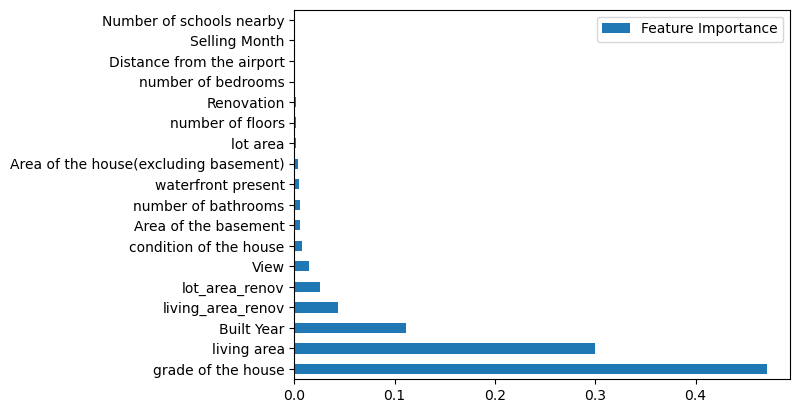

In [70]:
fi_data.plot(kind='barh')
plt.show()

## ***`Deployment`***

In [71]:
# Save the final model as a pickle file

with open('final_model_gb.pkl','wb') as file:
    pickle.dump(final_model,file)